## https://www.kaggle.com/competitions/umich-siads-696-f22-predicting-text-difficulty/leaderboard

In [1]:
import pandas as pd
import numpy as np
from nltk.tokenize import word_tokenize
from nltk import pos_tag
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.preprocessing import LabelEncoder
from collections import defaultdict
from nltk.corpus import wordnet as wn
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import f1_score
from sklearn import model_selection, naive_bayes, svm
from sklearn.metrics import accuracy_score
import gc
import pickle

In [15]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package punkt to /Users/jimbo/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /Users/jimbo/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/jimbo/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


True

### Import Training Data

In [3]:
# We split the original file in three parts so that it could be uploaded to GitHub.
# This function combines the split files into a single file
def combine_files(file1, file2, file3):
    
    d1 = pd.read_csv(file1)
    d2 = pd.read_csv(file2)
    d3 = pd.read_csv(file3)
    
    df = pd.concat([d1, d2, d3])
    
    return df

In [4]:
# Read in the training data
df = combine_files('./data/Wiki_Train_1.csv', './data/Wiki_Train_2.csv', './data/Wiki_Train_3.csv')
df.head()

,original_text,label
0,There is manuscript evidence that Austen conti...,1
1,"In a remarkable comparative analysis , Mandaea...",1
2,"Before Persephone was released to Hermes , who...",1
3,Cogeneration plants are commonly found in dist...,1
4,"Geneva -LRB- , ; , ; , ; ; -RRB- is the second...",1


### Create or Modify Variables

#### Lowercase Original Text

In [5]:
# Convert all characters to lower case strings
df['original_text'] = df['original_text'].str.lower()
df.head()

,original_text,label
0,there is manuscript evidence that austen conti...,1
1,"in a remarkable comparative analysis , mandaea...",1
2,"before persephone was released to hermes , who...",1
3,cogeneration plants are commonly found in dist...,1
4,"geneva -lrb- , ; , ; , ; ; -rrb- is the second...",1


#### Tokenize Text

In [6]:
# Create a new column with the tokenized original text
df['tokenized'] = df['original_text'].apply(lambda x: word_tokenize(x))
df.head()

,original_text,label,tokenized
0,there is manuscript evidence that austen conti...,1,"[there, is, manuscript, evidence, that, austen..."
1,"in a remarkable comparative analysis , mandaea...",1,"[in, a, remarkable, comparative, analysis, ,, ..."
2,"before persephone was released to hermes , who...",1,"[before, persephone, was, released, to, hermes..."
3,cogeneration plants are commonly found in dist...,1,"[cogeneration, plants, are, commonly, found, i..."
4,"geneva -lrb- , ; , ; , ; ; -rrb- is the second...",1,"[geneva, -lrb-, ,, ;, ,, ;, ,, ;, ;, -rrb-, is..."


#### Token Counts

In [7]:
# Create a new column that counts the number of tokens in each list
df['token_size'] = df['tokenized'].apply(lambda x: len(x))
df.head()

,original_text,label,tokenized,token_size
0,there is manuscript evidence that austen conti...,1,"[there, is, manuscript, evidence, that, austen...",43
1,"in a remarkable comparative analysis , mandaea...",1,"[in, a, remarkable, comparative, analysis, ,, ...",23
2,"before persephone was released to hermes , who...",1,"[before, persephone, was, released, to, hermes...",46
3,cogeneration plants are commonly found in dist...,1,"[cogeneration, plants, are, commonly, found, i...",39
4,"geneva -lrb- , ; , ; , ; ; -rrb- is the second...",1,"[geneva, -lrb-, ,, ;, ,, ;, ,, ;, ;, -rrb-, is...",36


#### Parts of Speech Tagging

In [16]:
df['pos'] = df['tokenized'].apply(lambda x: nltk.pos_tag(x))
df.head()

,original_text,label,tokenized,token_size,pos
0,there is manuscript evidence that austen conti...,1,"[there, is, manuscript, evidence, that, austen...",43,"[(there, EX), (is, VBZ), (manuscript, JJ), (ev..."
1,"in a remarkable comparative analysis , mandaea...",1,"[in, a, remarkable, comparative, analysis, ,, ...",23,"[(in, IN), (a, DT), (remarkable, JJ), (compara..."
2,"before persephone was released to hermes , who...",1,"[before, persephone, was, released, to, hermes...",46,"[(before, IN), (persephone, NN), (was, VBD), (..."
3,cogeneration plants are commonly found in dist...,1,"[cogeneration, plants, are, commonly, found, i...",39,"[(cogeneration, NN), (plants, NNS), (are, VBP)..."
4,"geneva -lrb- , ; , ; , ; ; -rrb- is the second...",1,"[geneva, -lrb-, ,, ;, ,, ;, ,, ;, ;, -rrb-, is...",36,"[(geneva, NN), (-lrb-, NN), (,, ,), (;, :), (,..."


#### Average Word Length

In [51]:
def average_word_length(word_list):
    temp_list = [len(word) for word in word_list]
    return np.mean(temp_list)

In [52]:
df['avg_token_len'] = df['tokenized'].apply(lambda x: average_word_length(x))
df.head()

### Exploratory Data Analysis

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

#### Label Counts: Simplified vs Not Simplified

In [65]:
label_counts = df['label'].value_counts().rename(index={0: 'Simplified', 1: 'Not Simplified'}).reset_index()
label_counts

,index,label
0,Simplified,208384
1,Not Simplified,208384


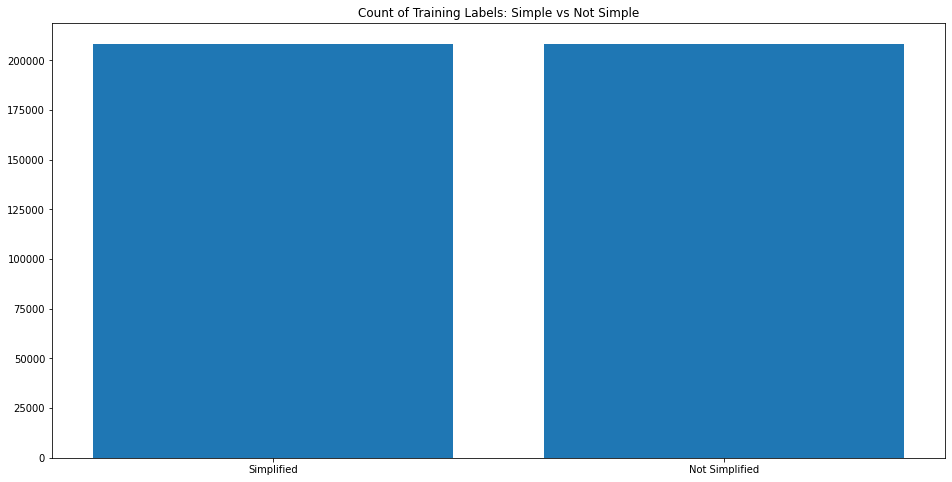

In [66]:
fig, ax = plt.subplots(figsize=(16, 8))

ax.bar(label_counts['index'], label_counts['label'])

plt.title('Count of Training Labels: Simple vs Not Simple')

plt.show()

#### Average Token Count per Original Text

In [67]:
avg_token_count = df.groupby('label', 
                            as_index=False)['token_size'].mean().replace({'label': {0: 'Simplified', 
                                                                                    1: 'Not Simplified'}})

avg_token_count

,label,token_size
0,Simplified,18.511613
1,Not Simplified,25.188724


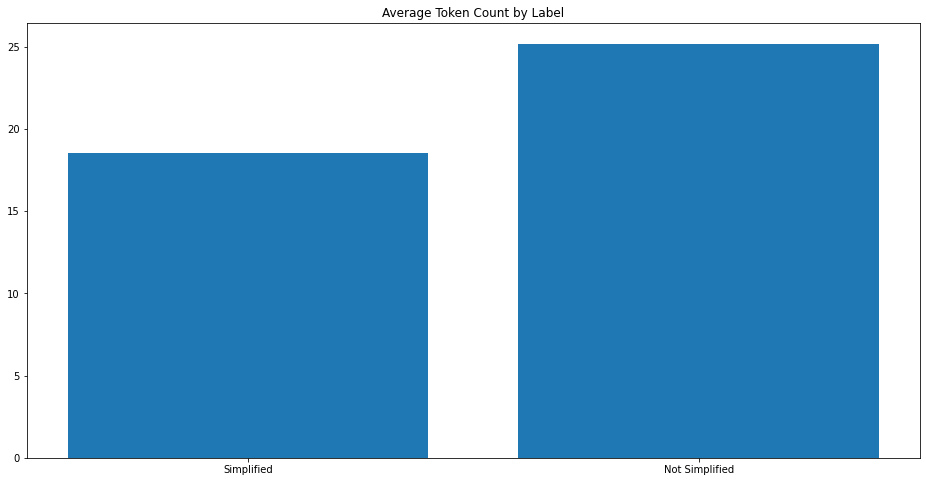

In [68]:
fig, ax = plt.subplots(figsize=(16, 8))

ax.bar(avg_token_count['label'], avg_token_count['token_size'])

plt.title('Average Token Count by Label')

plt.show()

#### Average Token Length per Original Text

In [69]:
avg_token_length = df.groupby('label', 
                            as_index=False)['avg_token_len'].mean().replace({'label': {0: 'Simplified', 
                                                                                    1: 'Not Simplified'}})

avg_token_length

,label,avg_token_len
0,Simplified,4.552155
1,Not Simplified,4.537199


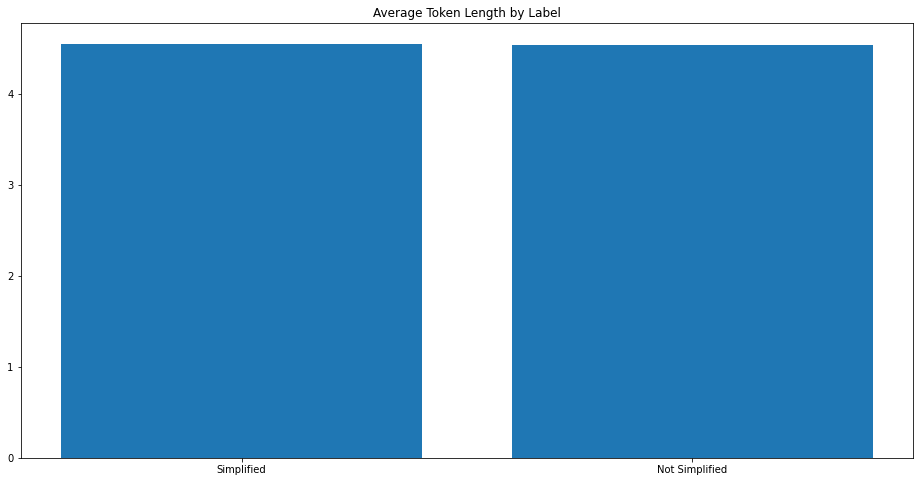

In [70]:
fig, ax = plt.subplots(figsize=(16, 8))

ax.bar(avg_token_length['label'], avg_token_length['avg_token_len'])

plt.title('Average Token Length by Label')

plt.show()

#### Token Count Distributions

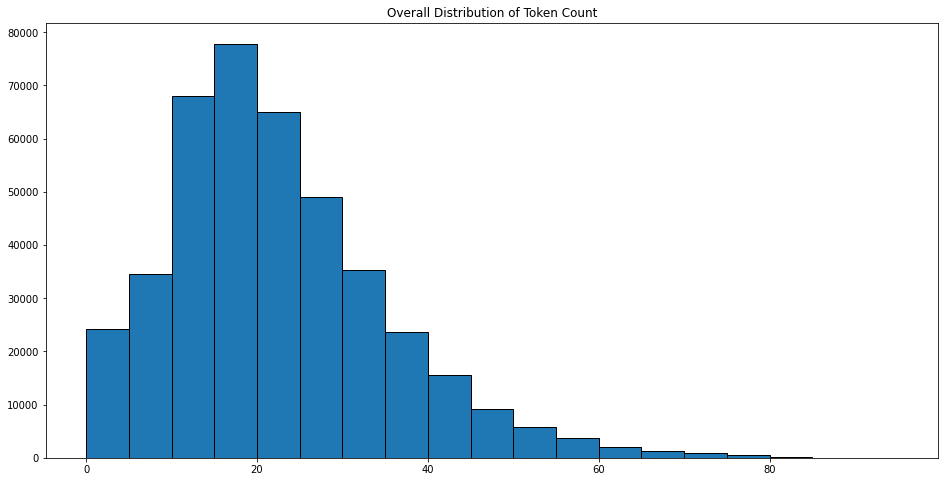

In [71]:
def rounduptobase(x, base=10):
    return x + (base - x%base)

fig, ax = plt.subplots(figsize=(16, 8))

ax.hist(df['token_size'], np.arange(0, rounduptobase(df['token_size'].max()), 5), lw=1, ec="black")

plt.title('Overall Distribution of Token Count')

plt.show()

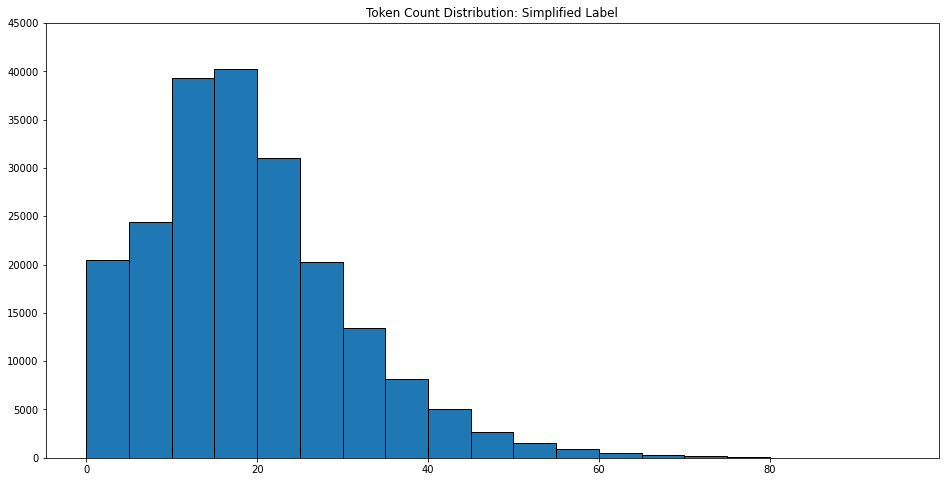

In [101]:
fig, ax = plt.subplots(figsize=(16, 8))

ax.hist(df[df['label']==0]['token_size'], np.arange(0, rounduptobase(df['token_size'].max()), 5), 
         lw=1, ec="black")

plt.title('Token Count Distribution: Simplified Label')
ax.set_ylim([0, 45000])

plt.show()

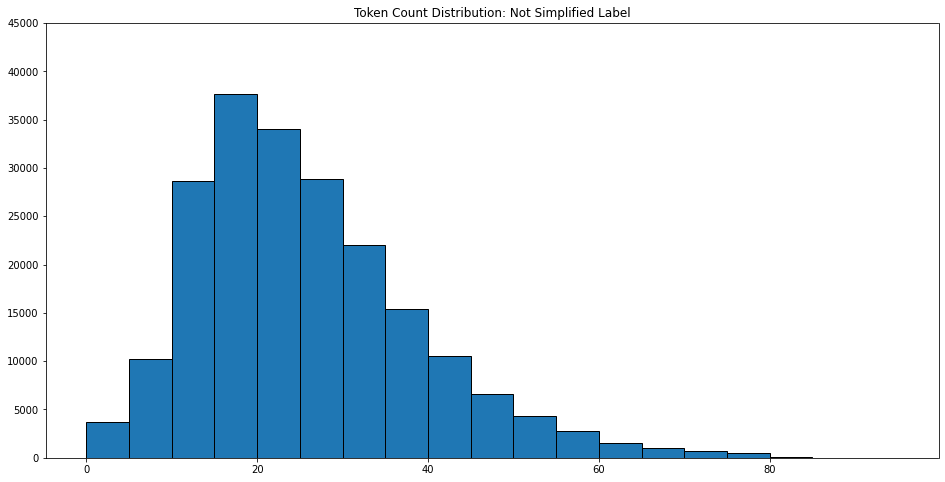

In [102]:
fig, ax = plt.subplots(figsize=(16, 8))

plt.hist(df[df['label']==1]['token_size'], np.arange(0, rounduptobase(df['token_size'].max()), 5), 
         lw=1, ec="black")

plt.title('Token Count Distribution: Not Simplified Label')
ax.set_ylim([0, 45000])

plt.show()

#### Token Count Distributions Z Test

In [89]:
X0 = np.mean(df[df['label']==0]['token_size'])
S0 = np.std(df[df['label']==0]['token_size'], ddof=1)

X1 = np.mean(df[df['label']==1]['token_size'])
S1 = np.std(df[df['label']==1]['token_size'], ddof=1)

In [90]:
print(S1, S0, X1, X0)

12.924627365520847 11.60420349460118 25.188723702395578 18.511613175675677


In [87]:
(X1 - X0)/(S1+S0)**(1/2)

1.3481886355477664

#### Parts of Speech Tagging Visualization

In [30]:
ndif_pos_list = [item for sublist in df[df['label']==0]['pos'].values.tolist() for item in sublist]
diff_pos_list = [item for sublist in df[df['label']==1]['pos'].values.tolist() for item in sublist]

In [74]:
ndif_fd = nltk.FreqDist(tag for (word, tag) in ndif_pos_list)
# ndif_fd.most_common()

In [75]:
diff_fd = nltk.FreqDist(tag for (word, tag) in diff_pos_list)
# diff_fd.most_common()

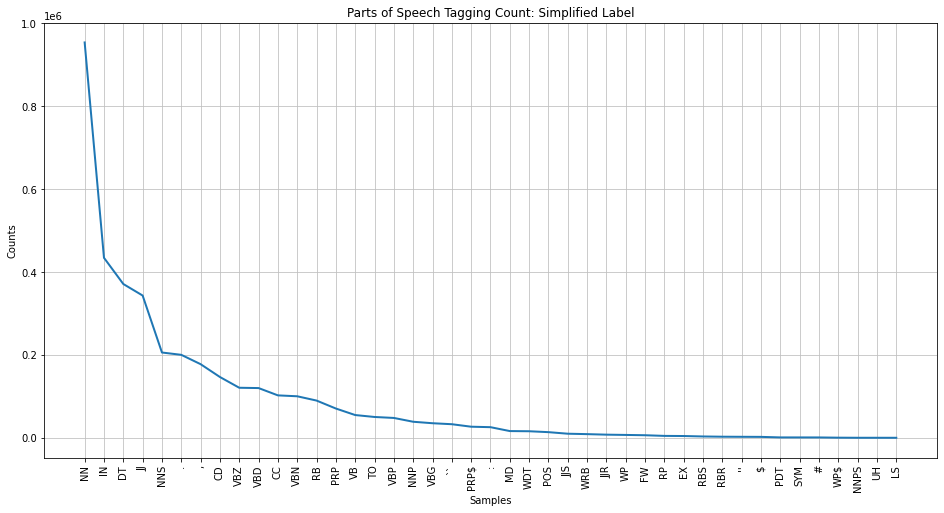

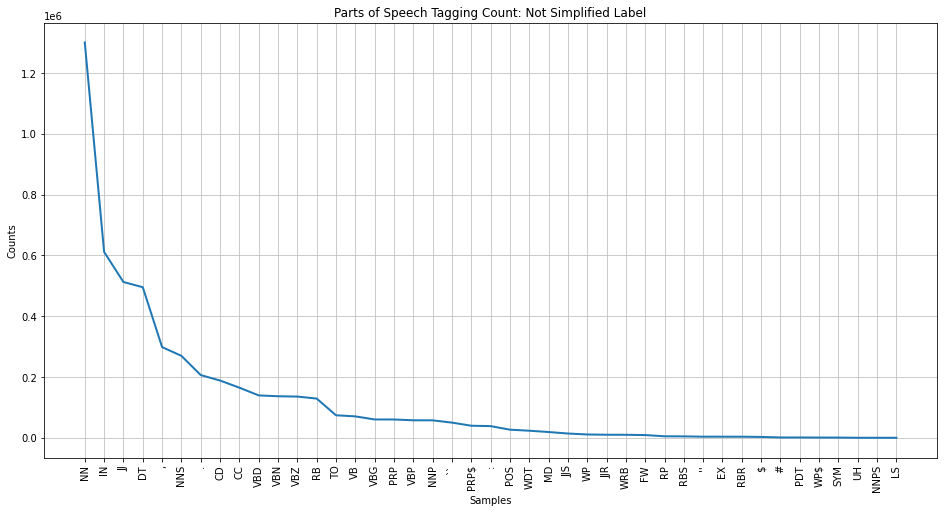

<AxesSubplot:title={'center':'Parts of Speech Tagging Count: Not Simplified Label'}, xlabel='Samples', ylabel='Counts'>

In [78]:
fig, ax = plt.subplots(figsize=(16, 8))
plt.title('Parts of Speech Tagging Count: Simplified Label')
ndif_fd.plot()

fig, ax = plt.subplots(figsize=(16, 8))
plt.title('Parts of Speech Tagging Count: Not Simplified Label')
diff_fd.plot()